In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq_full-wt')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 10,269
training + validation N: 40,249


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,validation,2,0,0,0,0,0,0,0,0,0,AATTGATGTCCGGTAGCTCACTCATTAGGCAGCCAAGGTTTTAGAC...
1,training,0,0,0,1,0,0,0,0,0,0,AATTCATGTGAGTTATGTCTCTCATTAGGCACCCCAGGCTTGAGAT...
2,training,1,0,0,0,0,0,0,0,0,0,AATTAATGTGAGTTAGCTCACTCATTGGACACCCCAGGCTTTACAC...
3,training,0,1,0,0,0,0,0,0,0,0,ACTTAATAAAAGTCAGCTCACTCATTAATCACCCCACGCTCTACAT...
4,training,0,0,0,0,0,3,0,0,0,0,AATTAATGTGAGTTATCTAACTCATTAGGCACCCCAGGCTTTACAC...


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=75, Y=10


In [4]:
from mavenn.src.layers.gpmap import CustomGPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(CustomGPMapLayer):
    """Represents an thermodynamic model of transcription
       regulation in E. Coli at the lac promoter, which 
       contains binding sites for RNAP and CRP.
    """

    def __init__(self, 
                 TF_start,
                 TF_end,
                 RNAP_start,
                 RNAP_end,
                 C,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.TF_start = TF_start
        self.TF_end = TF_end        
        self.RNAP_start = RNAP_start
        self.RNAP_end = RNAP_end        
        self.C=C
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        # form helpful variables
        self.L_TF = TF_end-TF_start
        self.L_RNAP = RNAP_end - RNAP_start
        
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        
        # define bias/chemical potential weight for crp
        self.mu_TF = self.add_weight(name='mu_TF',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap
        self.mu_RNAP = self.add_weight(name='mu_RNAP',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)


        # Define theta_TF_lc parameters
        theta_TF_lc_shape = (1, self.L_TF, self.C)

        theta_TF_lc_init = np.random.randn(*theta_TF_lc_shape)/np.sqrt(self.L_TF)
        self.theta_TF_lc = self.add_weight(name='theta_TF_lc',
                                        shape=theta_TF_lc_shape,
                                        initializer=Constant(theta_TF_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # Define theta_rnap_lc parameters
        theta_RNAP_lc_shape = (1, self.L_RNAP, self.C)

        theta_RNAP_lc_init = np.random.randn(*theta_RNAP_lc_shape)/np.sqrt(self.L_RNAP)
        self.theta_RNAP_lc = self.add_weight(name='theta_RNAP_lc',
                                        shape=theta_RNAP_lc_shape,
                                        initializer=Constant(theta_RNAP_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # define interaction term. Not sure if this needs regularization
        self.interaction = self.add_weight(name='interaction',
                               shape=(1,),
                               initializer=Constant(1.),
                               trainable=True,
                               regularizer=self.regularizer)
        
        # define tsat term. Not sure if this needs regularization
        self.tsat = self.add_weight(name='tsat',
                               shape=(1,),
                               initializer=Constant(1.),
                               trainable=True,
                               regularizer=self.regularizer)        
        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # extract locations of binding sites from entire lac-promoter sequence.
        x_TF_lc = x_lc[:,self.C * self.TF_start:self.C * self.TF_end]
        x_RNAP_lc = x_lc[:,self.C * self.RNAP_start: self.C * self.RNAP_end]
        
        # reshape according to crp and rnap lengths. 
        x_TF_lc = tf.reshape(x_TF_lc, [-1, self.L_TF, self.C])
        x_RNAP_lc = tf.reshape(x_RNAP_lc, [-1, self.L_RNAP, self.C])
                
        # compute delta G for crp    
        phi_TF = self.mu_TF + \
              tf.reshape(K.sum(self.theta_TF_lc * x_TF_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for rnap
        phi_RNAP = self.mu_RNAP + \
              tf.reshape(K.sum(self.theta_RNAP_lc * x_RNAP_lc, axis=[1, 2]),
                         shape=[-1, 1])            
        
        # compute rate of transcription
        t = (self.tsat)*(K.exp(-phi_RNAP)+K.exp(-phi_TF-phi_RNAP-self.interaction))/(1+K.exp(-phi_TF)+K.exp(-phi_RNAP)+K.exp(-phi_TF-phi_RNAP-self.interaction))
        
        # return rate of transcription
        return t


In [5]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'TF_start':1,
                'TF_end':27,
                'RNAP_start':34,
                'RNAP_end':75,
                'C':4,
                'regularizer':0.1}

# Create model
model = mavenn.Model(L=L, 
                     Y=Y,
                     alphabet='dna', 
                     regression_type='MPA', 
                     gpmap_type='custom',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer)

In [6]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df[y_cols],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          batch_size=100,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=True)


N = 40,249 observations set as training data.
Using 24.7% for validation.
Data shuffled.
Time to set data: 0.899 sec.
Epoch 1/1000
304/304 [==============================] - 4s 6ms/step - loss: 351.3719 - I_var: 0.0022 - val_loss: 336.7081 - val_I_var: 0.0162
Epoch 2/1000
304/304 [==============================] - 1s 3ms/step - loss: 327.0544 - I_var: 0.1010 - val_loss: 306.6193 - val_I_var: 0.2176
Epoch 3/1000
304/304 [==============================] - 1s 3ms/step - loss: 298.8899 - I_var: 0.3017 - val_loss: 291.0464 - val_I_var: 0.3535
Epoch 4/1000
304/304 [==============================] - 1s 3ms/step - loss: 285.2098 - I_var: 0.3965 - val_loss: 284.8253 - val_I_var: 0.4159
Epoch 5/1000
304/304 [==============================] - 1s 3ms/step - loss: 280.2075 - I_var: 0.4492 - val_loss: 280.7196 - val_I_var: 0.4628
Epoch 6/1000
304/304 [==============================] - 1s 3ms/step - loss: 278.6261 - I_var: 0.4756 - val_loss: 278.6376 - val_I_var: 0.4879
Epoch 7/1000
304/304 [========

304/304 [==============================] - 1s 3ms/step - loss: 270.4127 - I_var: 0.5531 - val_loss: 272.0349 - val_I_var: 0.5537
Epoch 58/1000
304/304 [==============================] - 1s 3ms/step - loss: 270.1695 - I_var: 0.5568 - val_loss: 272.4751 - val_I_var: 0.5491
Epoch 59/1000
304/304 [==============================] - 1s 3ms/step - loss: 269.6186 - I_var: 0.5527 - val_loss: 272.3965 - val_I_var: 0.5500
Epoch 60/1000
304/304 [==============================] - 1s 3ms/step - loss: 270.7961 - I_var: 0.5559 - val_loss: 272.1474 - val_I_var: 0.5530
Epoch 61/1000
304/304 [==============================] - 1s 3ms/step - loss: 269.9020 - I_var: 0.5538 - val_loss: 272.1145 - val_I_var: 0.5525
Epoch 62/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.3188 - I_var: 0.5552 - val_loss: 271.9192 - val_I_var: 0.5552
Epoch 63/1000
304/304 [==============================] - 1s 3ms/step - loss: 269.1047 - I_var: 0.5563 - val_loss: 271.8877 - val_I_var: 0.5560
Epoch 64/1000

304/304 [==============================] - 1s 3ms/step - loss: 269.4126 - I_var: 0.5819 - val_loss: 270.4054 - val_I_var: 0.5823
Epoch 115/1000
304/304 [==============================] - 1s 3ms/step - loss: 268.9767 - I_var: 0.5820 - val_loss: 270.4425 - val_I_var: 0.5826
Epoch 116/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.0821 - I_var: 0.5816 - val_loss: 270.3563 - val_I_var: 0.5833
Epoch 117/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.8446 - I_var: 0.5827 - val_loss: 270.3834 - val_I_var: 0.5829
Epoch 118/1000
304/304 [==============================] - 1s 3ms/step - loss: 269.4768 - I_var: 0.5838 - val_loss: 270.7055 - val_I_var: 0.5800
Epoch 119/1000
304/304 [==============================] - 1s 3ms/step - loss: 268.7251 - I_var: 0.5835 - val_loss: 270.4182 - val_I_var: 0.5832
Epoch 120/1000
304/304 [==============================] - 1s 3ms/step - loss: 268.7785 - I_var: 0.5837 - val_loss: 270.4487 - val_I_var: 0.5830
Epoch 1

Epoch 171/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.5730 - I_var: 0.6133 - val_loss: 269.3072 - val_I_var: 0.6077
Epoch 172/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.9133 - I_var: 0.6127 - val_loss: 269.0674 - val_I_var: 0.6103
Epoch 173/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.3273 - I_var: 0.6114 - val_loss: 269.4958 - val_I_var: 0.6058
Epoch 174/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.2736 - I_var: 0.6121 - val_loss: 269.2932 - val_I_var: 0.6085
Epoch 175/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.6359 - I_var: 0.6104 - val_loss: 268.9348 - val_I_var: 0.6125
Epoch 176/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.1890 - I_var: 0.6153 - val_loss: 268.9171 - val_I_var: 0.6126
Epoch 177/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.2048 - I_var: 0.6153 - val_loss: 270.0468 - val_I_var:

Epoch 228/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.8993 - I_var: 0.6235 - val_loss: 269.0181 - val_I_var: 0.6182
Epoch 229/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.7329 - I_var: 0.6269 - val_loss: 269.0103 - val_I_var: 0.6185
Epoch 230/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.9021 - I_var: 0.6270 - val_loss: 268.9086 - val_I_var: 0.6196
Epoch 231/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.8793 - I_var: 0.6292 - val_loss: 268.8149 - val_I_var: 0.6207
Epoch 232/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.9550 - I_var: 0.6265 - val_loss: 268.6908 - val_I_var: 0.6222
Epoch 233/1000
304/304 [==============================] - 1s 3ms/step - loss: 267.0023 - I_var: 0.6254 - val_loss: 268.3958 - val_I_var: 0.6253
Epoch 234/1000
304/304 [==============================] - 1s 3ms/step - loss: 266.0281 - I_var: 0.6288 - val_loss: 268.3007 - val_I_var:

304/304 [==============================] - 1s 3ms/step - loss: 266.6879 - I_var: 0.6313 - val_loss: 268.1021 - val_I_var: 0.6302
Epoch 285/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.4403 - I_var: 0.6342 - val_loss: 267.9011 - val_I_var: 0.6324
Epoch 286/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.3616 - I_var: 0.6372 - val_loss: 268.2749 - val_I_var: 0.6287
Epoch 287/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.0282 - I_var: 0.6353 - val_loss: 267.8613 - val_I_var: 0.6329
Epoch 288/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.7931 - I_var: 0.6328 - val_loss: 267.7901 - val_I_var: 0.6335
Epoch 289/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.6766 - I_var: 0.6347 - val_loss: 267.9001 - val_I_var: 0.6323
Epoch 290/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.0728 - I_var: 0.6335 - val_loss: 267.9732 - val_I_var: 0.6315
Epoch 2

Epoch 341/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.3850 - I_var: 0.6389 - val_loss: 267.6623 - val_I_var: 0.6369
Epoch 342/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.2437 - I_var: 0.6412 - val_loss: 267.6923 - val_I_var: 0.6365
Epoch 343/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.5450 - I_var: 0.6387 - val_loss: 267.7483 - val_I_var: 0.6358
Epoch 344/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.9347 - I_var: 0.6396 - val_loss: 267.8409 - val_I_var: 0.6346
Epoch 345/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.5895 - I_var: 0.6399 - val_loss: 267.3804 - val_I_var: 0.6396
Epoch 346/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.7205 - I_var: 0.6400 - val_loss: 267.5959 - val_I_var: 0.6374
Epoch 347/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.5977 - I_var: 0.6374 - val_loss: 267.8565 - val_I_var:

Epoch 398/1000
304/304 [==============================] - 1s 3ms/step - loss: 263.0415 - I_var: 0.6449 - val_loss: 267.3771 - val_I_var: 0.6409
Epoch 399/1000
304/304 [==============================] - 1s 3ms/step - loss: 263.3560 - I_var: 0.6456 - val_loss: 267.1427 - val_I_var: 0.6437
Epoch 400/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.3644 - I_var: 0.6457 - val_loss: 267.1898 - val_I_var: 0.6431
Epoch 401/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.0529 - I_var: 0.6459 - val_loss: 267.1003 - val_I_var: 0.6441
Epoch 402/1000
304/304 [==============================] - 1s 3ms/step - loss: 263.6222 - I_var: 0.6460 - val_loss: 267.2013 - val_I_var: 0.6430
Epoch 403/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.3472 - I_var: 0.6439 - val_loss: 267.2366 - val_I_var: 0.6426
Epoch 404/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.7056 - I_var: 0.6431 - val_loss: 267.5057 - val_I_var:

Epoch 455/1000
304/304 [==============================] - 1s 3ms/step - loss: 262.5197 - I_var: 0.6469 - val_loss: 267.3466 - val_I_var: 0.6428
Epoch 456/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.2261 - I_var: 0.6489 - val_loss: 266.9181 - val_I_var: 0.6474
Epoch 457/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.2870 - I_var: 0.6468 - val_loss: 267.0250 - val_I_var: 0.6464
Epoch 458/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.0212 - I_var: 0.6486 - val_loss: 266.9245 - val_I_var: 0.6474
Epoch 459/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.3642 - I_var: 0.6504 - val_loss: 266.9808 - val_I_var: 0.6466
Epoch 460/1000
304/304 [==============================] - 1s 3ms/step - loss: 265.4855 - I_var: 0.6489 - val_loss: 267.2928 - val_I_var: 0.6435
Epoch 461/1000
304/304 [==============================] - 1s 3ms/step - loss: 264.7610 - I_var: 0.6463 - val_loss: 266.9990 - val_I_var:

On test data:
I_var_test: 0.639 +- 0.009 bits
I_pred_test: 0.727 +- 0.010 bits


Text(0.5, 1.0, 'training hisotry')

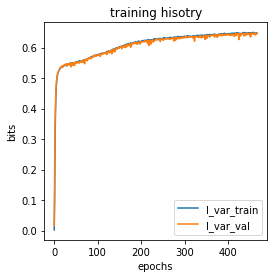

In [7]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
#ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
#ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

In [8]:
interaction_term = model.get_nn().layers[2].get_weights()[4]
crp_weights = model.get_nn().layers[2].get_weights()[2][0]
rnap_weights = model.get_nn().layers[2].get_weights()[3][0]
print(f'interaction term = {interaction_term[0]:.3f} k_cal/mol')

interaction term = 3.502 k_cal/mol


In [9]:
model.get_nn().layers[2].get_weights()[5]

array([4.2548933], dtype=float32)

In [10]:
crp_df = pd.DataFrame(crp_weights,columns=model.alphabet)
rnap_df = pd.DataFrame(rnap_weights,columns=model.alphabet)

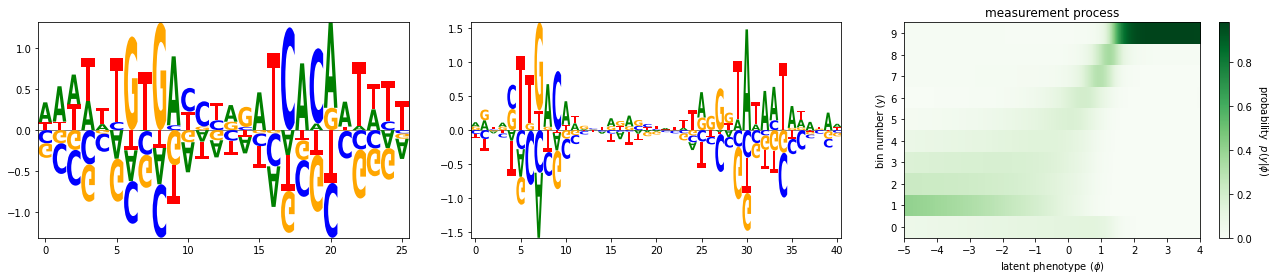

In [12]:
# # Get G-P map parameters in matrix form
# theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[18,4])

logomaker.Logo(crp_df,ax=axs[0],center_values=True)
logomaker.Logo(rnap_df,ax=axs[1],center_values=True)

# # Right panel: draw measurement process as heatmap
ax = axs[2]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('thermodynmic_custom_gpmap_mpa_visualization_sort_seq.png',bbox_index='tight',dpi=300)
# plt.show()